In [592]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install scipy
!pip install imbalanced-learn

### Загрузка данных

In [5]:
# Загружаем библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import optuna
import matplotlib.pyplot as plt
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import optuna
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Загрузка данных
train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')



# Просмотр первых значений целевой переменной
print(train['Target'].head())

id
0    Graduate
1     Dropout
2     Dropout
3    Enrolled
4    Graduate
Name: Target, dtype: object


### Определение катеогориальных и числовых признаков

In [7]:
# Определение категориальных и числовых признаков
categorical_columns = [
    "Marital status", "Application mode", "Application order", "Course",
    "Daytime/evening attendance", "Previous qualification", "Nacionality",
    "Mother's qualification", "Father's qualification", "Mother's occupation",
    "Father's occupation", "Displaced", "Educational special needs", "Debtor",
    "Tuition fees up to date", "Gender", "Scholarship holder", "International"
]

cat_features = [train.columns.get_loc(col) for col in categorical_columns]

numerical_columns = [
    "Previous qualification (grade)", "Admission grade", "Age at enrollment",
    "Curricular units 1st sem (credited)", "Curricular units 1st sem (enrolled)",
    "Curricular units 1st sem (evaluations)", "Curricular units 1st sem (approved)",
    "Curricular units 1st sem (grade)", "Curricular units 1st sem (without evaluations)",
    "Curricular units 2nd sem (credited)", "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (evaluations)", "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (grade)", "Curricular units 2nd sem (without evaluations)",
    "Unemployment rate", "Inflation rate", "GDP"
]

### Кодирование целевой переменной (в результате получаем три класса)

In [9]:
# Кодирование целевой переменной
le = LabelEncoder()
train['Target'] = le.fit_transform(train['Target'])

# Просмотр уникальных значений после преобразования
unique_values = sorted(zip(le.transform(le.classes_), le.classes_))
print("Преобразованные значения 'Target':", train['Target'].unique())

Преобразованные значения 'Target': [2 0 1]


### Нормализация числовых признаков

In [13]:
# Нормализация числовых признаков
scaler = MinMaxScaler(feature_range=(0, 1))
train[numerical_columns] = scaler.fit_transform(train[numerical_columns])

# Проверка результата нормализации
print(train.head())


    Marital status  Application mode  Application order  Course  \
id                                                                
0                1                 1                  1    9238   
1                1                17                  1    9238   
2                1                17                  2    9254   
3                1                 1                  3    9500   
4                1                 1                  2    9500   

    Daytime/evening attendance  Previous qualification  \
id                                                       
0                            1                       1   
1                            1                       1   
2                            1                       1   
3                            1                       1   
4                            1                       1   

    Previous qualification (grade)  Nacionality  Mother's qualification  \
id                                              

### Подготовка данных для обучения, балансировка классов, разделение выборки на обучающую и тестовую

In [15]:
# Подготовка данных для обучения
X = train.drop('Target', axis=1)  # Все признаки
y = train['Target']  # Целевая переменная

# Применение SMOTE для устранения дисбаланса классов
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

### Загрузка моделей RandomForestClassifier, CatBoostClassifier, XGBClassifier  с оптимальными гиперапараметрами, найденных при помощи Optuna. Данные модели будут испрользоваться для построения ансамбля.

In [17]:
# Загрузка моделей с оптимальными гиперпараметрами
rf_model = RandomForestClassifier(
    n_estimators=65, 
    max_depth=10, 
    min_samples_split=6, 
    min_samples_leaf=1, 
    max_features=None
)

catboost_model = CatBoostClassifier(
    iterations=472,
    depth=6,
    learning_rate=0.09526628317155486,
    l2_leaf_reg=8.543439603088149e-07,
    verbose=0,  # Отключает вывод
    classes_count=3

)

xgboost_model = XGBClassifier(
    objective='multi:softmax', 
    num_class=3,  # Количество классов
    random_state=42,
    max_depth=12, 
    learning_rate=0.1380959235295076, 
    n_estimators=229, 
    colsample_bytree=0.9428442050675058, 
    min_child_weight=4, 
    subsample=0.9200515940656013, 
    colsample_bylevel=0.6455519399349366, 
    colsample_bynode=0.6808130293292364, 
    max_delta_step=27
)


**Мета-модель** использует **GradientBoostingClassifier** с заранее подобранными гиперпараметрами. Эта мета-модель будет объединять результаты нескольких базовых моделей для получения итогового предсказания. Выбор в пользу **GradientBoostingClassifier** объясняется оптимальной производительностью и лучшими результатами по сравнению с аналогами.

#### Базовые модели: Для создания ансамбля используются три модели:

* CatBoostClassifier
* XGBClassifier
* RandomForestClassifier

#### Эти модели являются базовыми, и их результаты будут объединяться с помощью мета-модели.

**StackingClassifier**: Затем создается объект StackingClassifier, который принимает эти базовые модели и мета-модель. Стекинг работает следующим образом: базовые модели сначала обучаются на обучающих данных и предсказывают результаты для каждого экземпляра. Эти предсказания затем подаются на вход мета-модели, которая обучается на этих предсказаниях и выдает финальный результат. 

Выбор **StackingClassifier** оказался более эффективным по сравнению с **VotingClassifier**. При использовании **VotingClassifier** результаты не превосходили показатели отдельно взятой модели **XGBClassifier** из ансамбля- ансамбль лишь повторял уровень точности этой модели. Более того, для достижения приемлемых результатов в Voting приходилось задавать значительный вес для **XGBClassifier** (в пропорции 50:1 относительно других моделей), что делало ансамбль зависимым от одной модели.

В отличие от **Voting**, **StackingClassifier** позволил лучше использовать разнообразие базовых моделей. Мета-модель на основе **GradientBoostingClassifier** смогла эффективно комбинировать их предсказания, что привело к улучшению итогового результата и сделало ансамбль более сбалансированным, правда, более затратным по ресурсам.

**Метрики**: Для каждой модели (включая **StackingClassifier**) выводятся метрики классификации с помощью **classification_report**, который включает показатели **точности (precision)**, **полноты (recall)** и **F1-меры** для каждого класса.

**Отчет по моделям**: Для каждой из базовых моделей также выводится отчет, включающий точность и другие метрики. 

**Вывод по ансамблю**: Ансамбль показал сбалансированные результаты, добившись точности выше любой отдельной модели. **XGBoost** показывает результаты, близкие к ансамблю. Однако ансамбль незначительно превосходит его в точности **(0.8719-0.8724 против 0.8705)**, так как может использовать предсказания других моделей для повышения общей производительности. **CatBoost** имеет близкие результаты, но уступает ансамблю по всем метрикам. **RandomForest** существенно уступает ансамблю, особенно по классу 1. Это связано с ограниченной сложностью модели по сравнению с **CatBoost** и **XGBoost**.


In [19]:
def draw_metrics(y_test, y_pred): 
    # Вычислить и отобразить матрицу путаницы
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.values()))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    
    # Создание отчета о классификации
    report = classification_report(y_test, y_pred, target_names=list(label_mapping.values()), output_dict=True)
    
    # Извлекайте баллы recall, precision и f1-score для каждого класса
    precision = [report[class_name]['precision'] for class_name in label_mapping.values()]
    recall = [report[class_name]['recall'] for class_name in label_mapping.values()]
    f1_scores = [report[class_name]['f1-score'] for class_name in label_mapping.values()]
    
    # Построение графиков показателей по классам
    x = range(len(label_mapping))
    
    plt.figure(figsize=(12, 6))
    plt.bar(x, precision, width=0.2, label='Precision', color='b', align='center')
    plt.bar([p + 0.2 for p in x], recall, width=0.2, label='Recall', color='g', align='center')
    plt.bar([p + 0.4 for p in x], f1_scores, width=0.2, label='F1 Score', color='r', align='center')
    
    plt.xlabel('Классы')
    plt.ylabel('Оценка')
    plt.title('Показатели классификации по классам')
    plt.xticks([p + 0.2 for p in x], list(label_mapping.values()))
    plt.legend()
    plt.show()

In [21]:
label_mapping = {0: 'Enrolled', 1: 'Graduate', 2: 'Dropout'}

In [ ]:
def draw_metrics(y_test, y_pred): 
    # Вычислить и отобразить матрицу путаницы
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.values()))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    
    # Создание отчета о классификации
    report = classification_report(y_test, y_pred, target_names=list(label_mapping.values()), output_dict=True)
    
    # Извлекайте баллы recall, precision и f1-score для каждого класса
    precision = [report[class_name]['precision'] for class_name in label_mapping.values()]
    recall = [report[class_name]['recall'] for class_name in label_mapping.values()]
    f1_scores = [report[class_name]['f1-score'] for class_name in label_mapping.values()]
    
    # Построение графиков показателей по классам
    x = range(len(label_mapping))
    
    plt.figure(figsize=(12, 6))
    plt.bar(x, precision, width=0.2, label='Precision', color='b', align='center')
    plt.bar([p + 0.2 for p in x], recall, width=0.2, label='Recall', color='g', align='center')
    plt.bar([p + 0.4 for p in x], f1_scores, width=0.2, label='F1 Score', color='r', align='center')
    
    plt.xlabel('Классы')
    plt.ylabel('Оценка')
    plt.title('Показатели классификации по классам')
    plt.xticks([p + 0.2 for p in x], list(label_mapping.values()))
    plt.legend()
    plt.show()

In [23]:
# Мета-модель - заменили LogisticRegression на RandomForestClassifier
def fit_stacking_classifier(X_train, y_train, X_test, y_test):
    # Импорт необходимых библиотек
    from sklearn.metrics import classification_report, accuracy_score
    from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier

    # Настройка мета-модели
    meta_model = GradientBoostingClassifier(
        n_estimators=135, 
        learning_rate=0.044881081952192946, 
        max_depth=3, 
        subsample=0.6272561584850668, 
        random_state=42
    )

    # Создание StackingClassifier
    stacking_clf = StackingClassifier(
        estimators=[
            ('catboost', catboost_model), 
            ('xgboost', xgboost_model), 
            ('randomforest', rf_model)
        ],
        final_estimator=meta_model,
        verbose=1
    )

    # Обучение модели
    stacking_clf.fit(X_train, y_train)

    # Предсказания для stacking-модели
    y_pred_stacking = stacking_clf.predict(X_test)

    # Оценка StackingClassifier
    accuracy = accuracy_score(y_test, y_pred_stacking)
    print("Classification Report for StackingClassifier:")
    print(classification_report(y_test, y_pred_stacking))
    print(f"StackingClassifier Accuracy: {accuracy:.4f}")

    # Отрисовка графиков для stacking_clf
    print("Metrics for StackingClassifier:")
    draw_metrics(y_test, y_pred_stacking)

    # Оценка базовых моделей
    predictions = {}  # Словарь для хранения предсказаний
    for name, model in [
        ('catboost', catboost_model), 
        ('xgboost', xgboost_model), 
        ('randomforest', rf_model)
    ]:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)  # Предсказания сохраняются в переменную
        predictions[name] = y_pred  # Сохраняем предсказания в словарь
        acc = accuracy_score(y_test, y_pred)
        print(f"Accuracy of {name}: {acc}")
        print(f"Classification Report for {name}:")
        print(classification_report(y_test, y_pred))

        # Отрисовка графиков для каждой модели
        print(f"Metrics for {name}:")
        draw_metrics(y_test, y_pred)

Classification Report for StackingClassifier:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      7223
           1       0.84      0.83      0.84      7201
           2       0.86      0.92      0.89      7346

    accuracy                           0.87     21770
   macro avg       0.87      0.87      0.87     21770
weighted avg       0.87      0.87      0.87     21770

StackingClassifier Accuracy: 0.8722
Metrics for StackingClassifier:


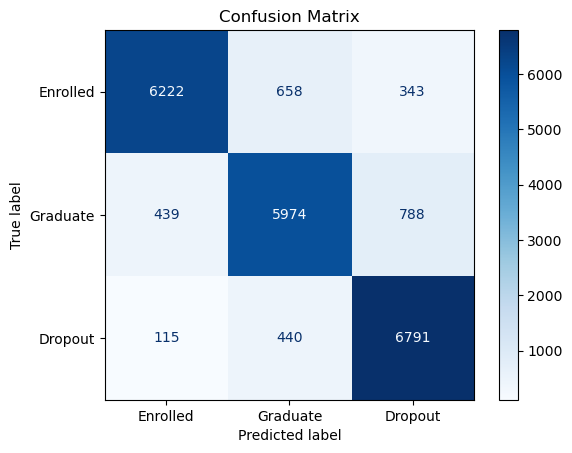

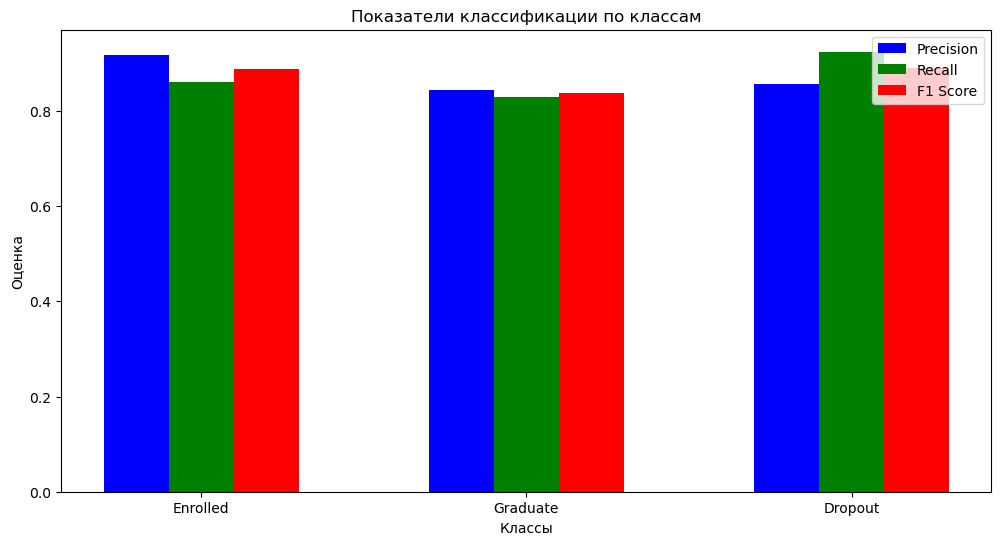

Accuracy of catboost: 0.8583371612310519
Classification Report for catboost:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      7223
           1       0.82      0.82      0.82      7201
           2       0.86      0.92      0.89      7346

    accuracy                           0.86     21770
   macro avg       0.86      0.86      0.86     21770
weighted avg       0.86      0.86      0.86     21770

Metrics for catboost:


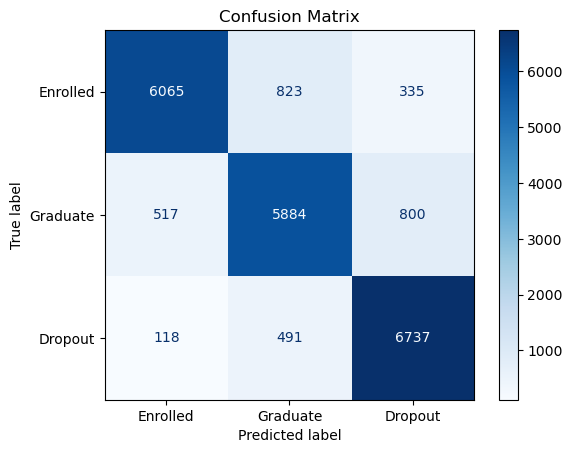

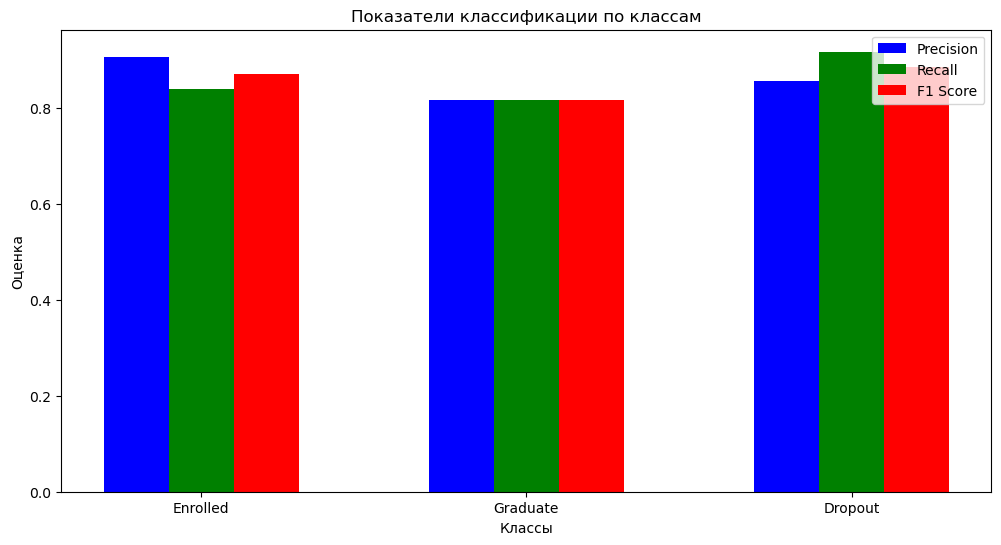

Accuracy of xgboost: 0.870509875976114
Classification Report for xgboost:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      7223
           1       0.84      0.83      0.84      7201
           2       0.86      0.92      0.89      7346

    accuracy                           0.87     21770
   macro avg       0.87      0.87      0.87     21770
weighted avg       0.87      0.87      0.87     21770

Metrics for xgboost:


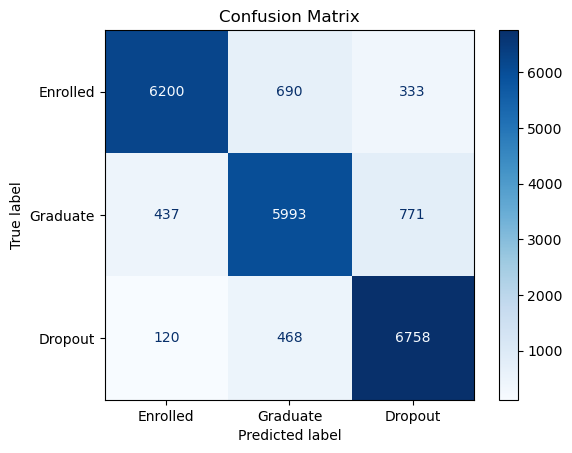

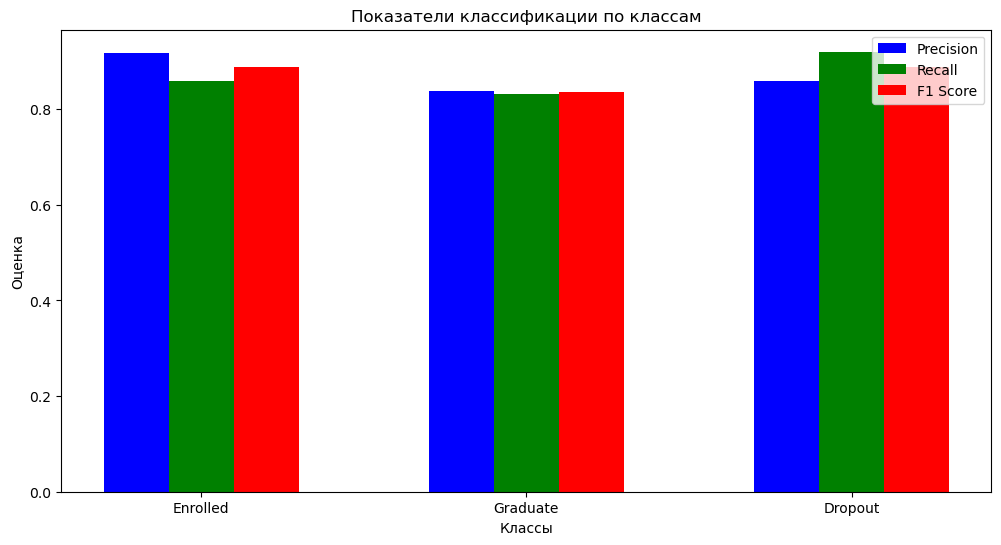

Accuracy of randomforest: 0.8440973817179604
Classification Report for randomforest:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      7223
           1       0.78      0.81      0.80      7201
           2       0.84      0.91      0.87      7346

    accuracy                           0.84     21770
   macro avg       0.85      0.84      0.84     21770
weighted avg       0.85      0.84      0.84     21770

Metrics for randomforest:


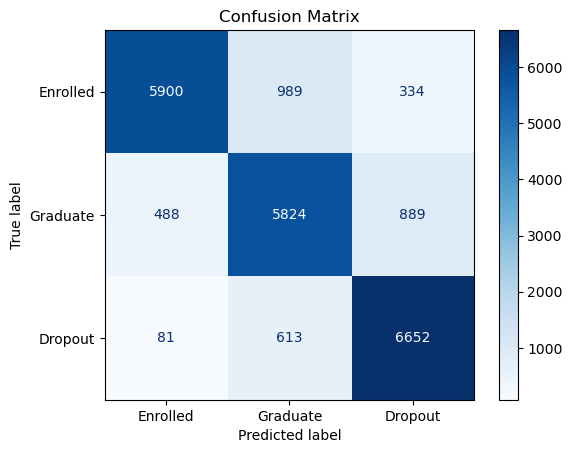

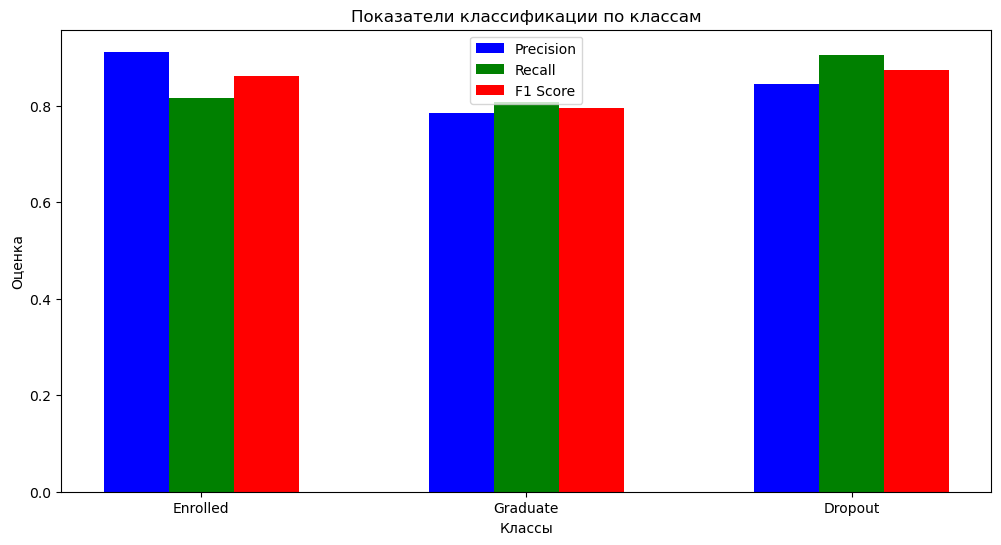

In [25]:
fit_stacking_classifier(X_train, y_train, X_test, y_test)

# Сравнимые результаты были показаны на данных, очищенных от выбросов.

Classification Report for StackingClassifier:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      7301
           1       0.84      0.83      0.83      7213
           2       0.85      0.92      0.88      7244

    accuracy                           0.87     21758
   macro avg       0.87      0.87      0.87     21758
weighted avg       0.87      0.87      0.87     21758

StackingClassifier Accuracy: 0.8703
Metrics for StackingClassifier:


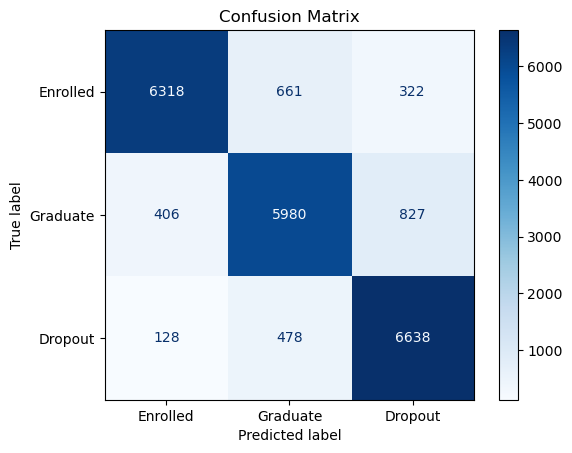

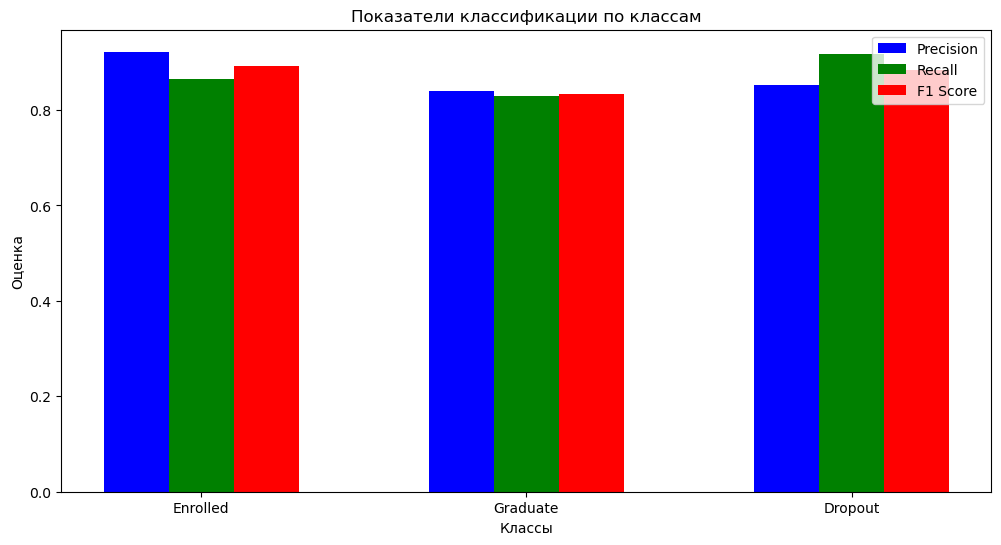

Accuracy of catboost: 0.857707509881423
Classification Report for catboost:
              precision    recall  f1-score   support

           0       0.91      0.84      0.88      7301
           1       0.82      0.81      0.82      7213
           2       0.85      0.91      0.88      7244

    accuracy                           0.86     21758
   macro avg       0.86      0.86      0.86     21758
weighted avg       0.86      0.86      0.86     21758

Metrics for catboost:


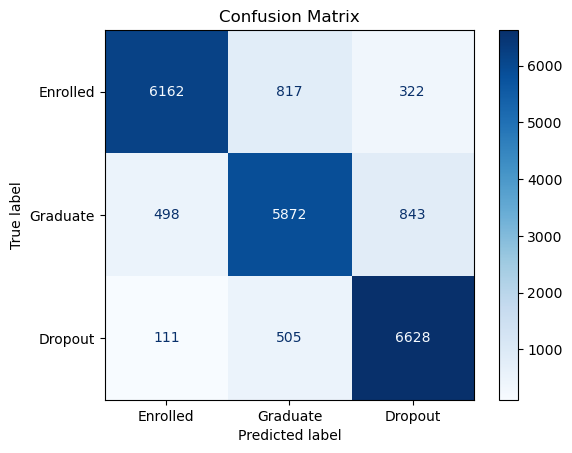

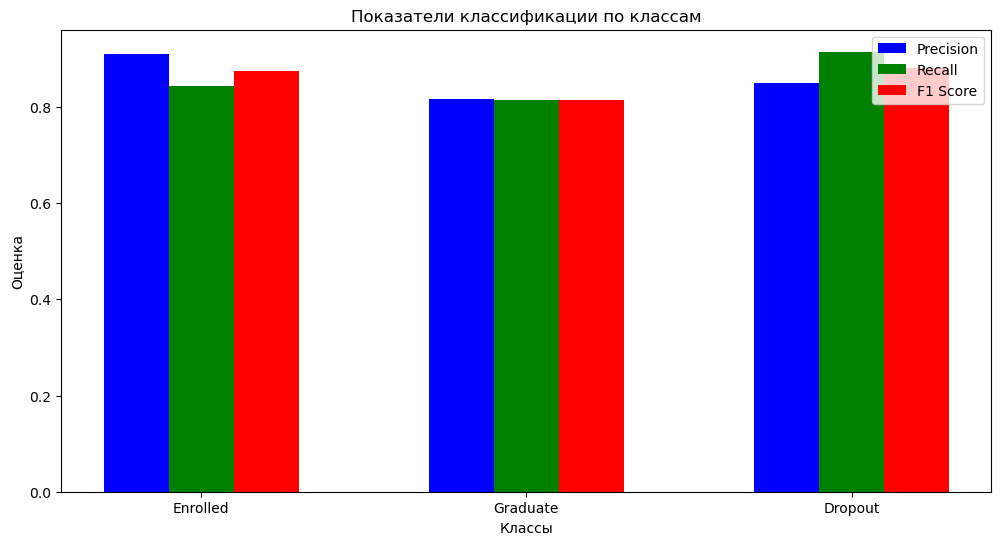

Accuracy of xgboost: 0.8696111774979318
Classification Report for xgboost:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      7301
           1       0.83      0.83      0.83      7213
           2       0.85      0.91      0.88      7244

    accuracy                           0.87     21758
   macro avg       0.87      0.87      0.87     21758
weighted avg       0.87      0.87      0.87     21758

Metrics for xgboost:


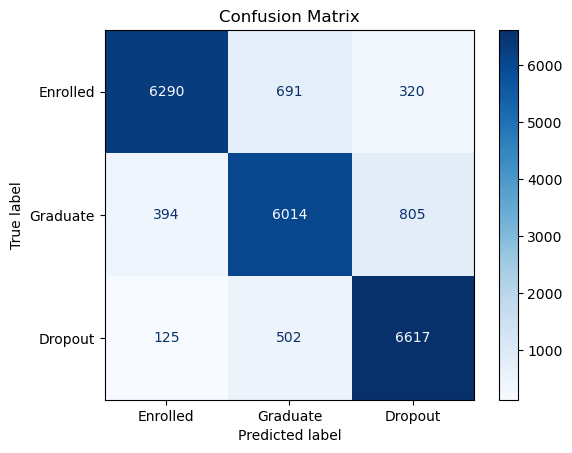

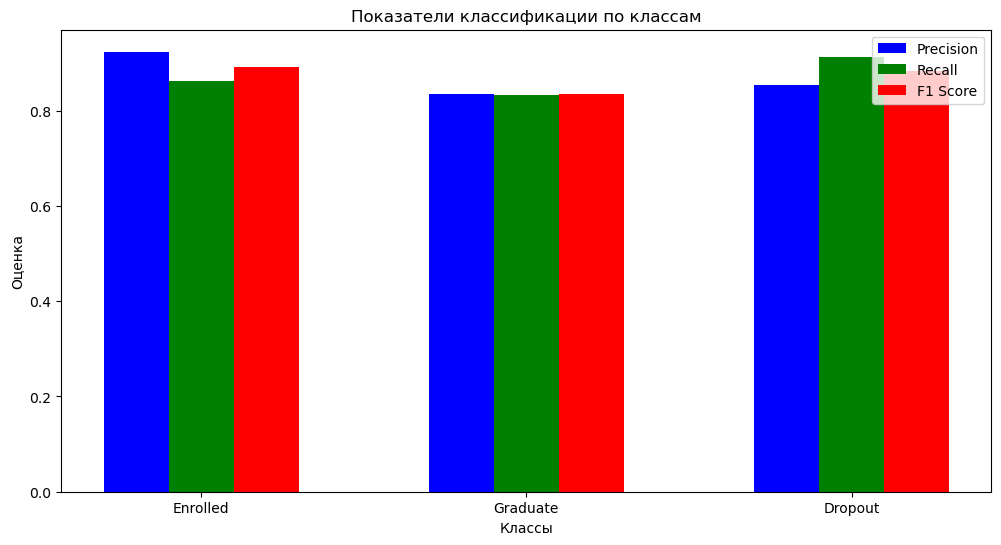

Accuracy of randomforest: 0.8403805496828752
Classification Report for randomforest:
              precision    recall  f1-score   support

           0       0.92      0.82      0.86      7301
           1       0.78      0.81      0.79      7213
           2       0.84      0.90      0.87      7244

    accuracy                           0.84     21758
   macro avg       0.84      0.84      0.84     21758
weighted avg       0.84      0.84      0.84     21758

Metrics for randomforest:


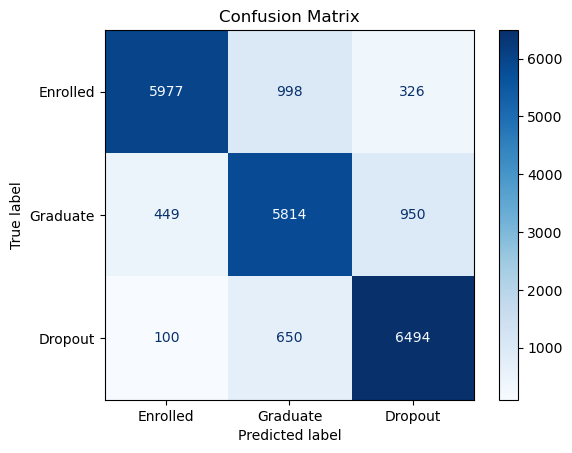

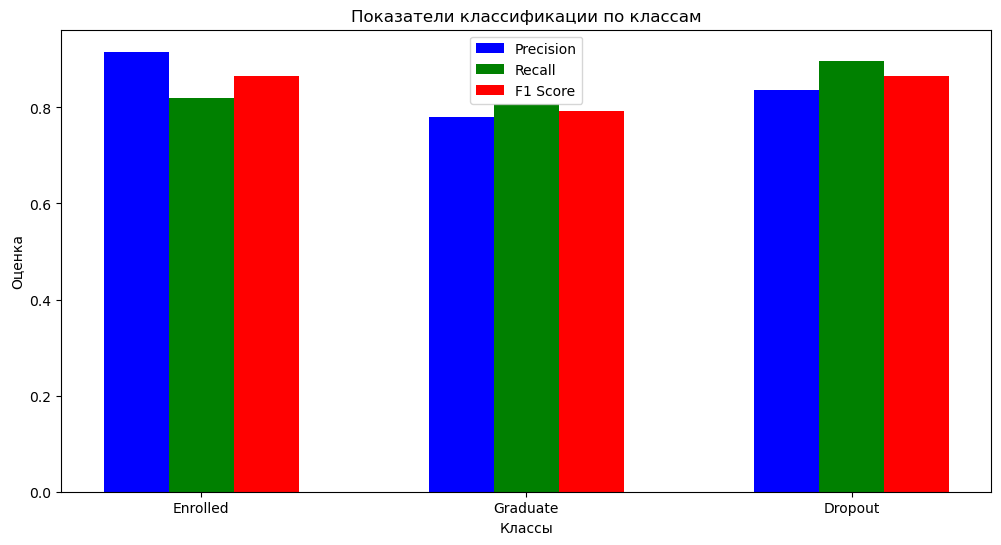

In [39]:
# Загружаем библиотеки
from sklearn.cluster import DBSCAN
# Загрузка данных
train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')


# Определение категориальных и числовых признаков
categorical_columns = [
    "Marital status", "Application mode", "Application order", "Course",
    "Daytime/evening attendance", "Previous qualification", "Nacionality",
    "Mother's qualification", "Father's qualification", "Mother's occupation",
    "Father's occupation", "Displaced", "Educational special needs", "Debtor",
    "Tuition fees up to date", "Gender", "Scholarship holder", "International"
]

cat_features = [train.columns.get_loc(col) for col in categorical_columns]

numerical_columns = [
    "Previous qualification (grade)", "Admission grade", "Age at enrollment",
    "Curricular units 1st sem (credited)", "Curricular units 1st sem (enrolled)",
    "Curricular units 1st sem (evaluations)", "Curricular units 1st sem (approved)",
    "Curricular units 1st sem (grade)", "Curricular units 1st sem (without evaluations)",
    "Curricular units 2nd sem (credited)", "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (evaluations)", "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (grade)", "Curricular units 2nd sem (without evaluations)",
    "Unemployment rate", "Inflation rate", "GDP"
]

# Кодирование целевой переменной
le = LabelEncoder()
train['Target'] = le.fit_transform(train['Target'])


# Нормализация числовых признаков
scaler = MinMaxScaler(feature_range=(0, 1))
train[numerical_columns] = scaler.fit_transform(train[numerical_columns])

# Применение DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(train[numerical_columns])

# Добавление результатов кластеризации в DataFrame
train['Cluster'] = clusters

# Выделение выбросов (шум обозначается как -1)
outliers_dbscan = train[train['Cluster'] == -1]

# Подготовка данных для обучения
X = train.drop('Target', axis=1)  # Все признаки
y = train['Target']  # Целевая переменная

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Подготовка данных
without_outliers = train[train['Cluster'] > -1]
without_outliers = without_outliers.drop('Cluster', axis=1)
X = without_outliers.drop('Target', axis=1)
y = without_outliers['Target']

# Применение SMOTE для устранения дисбаланса классов
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)


fit_stacking_classifier(X_train, y_train, X_test, y_test)
